# 07 — Mini-Projet End-to-End
Objectif : réaliser un flux complet depuis le chargement jusqu'à un petit modèle prédictif.

**Tâche :** prédire `quantity` à partir de features simples (prix, promo, mois, jour_semaine, catégorie).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

DATA_DIR = Path('data')
ventes = pd.read_csv(DATA_DIR / 'ventes.csv', parse_dates=['date'])
produits = pd.read_csv(DATA_DIR / 'produits.csv')
df = ventes.merge(produits[['product_id','category']], on='product_id', how='left')

# Features
df['month'] = df['date'].dt.month
df['dow'] = df['date'].dt.dayofweek

# Nettoyage minimal
df['price'] = df['price'].fillna(df['price'].median())
df['quantity'] = df['quantity'].fillna(0).clip(lower=0)

# Add price_per_unit feature (use 'total' if present, else price/quantity fallback)
if 'total' in df.columns:
    df['price_per_unit'] = df['total'] / df['quantity'].replace(0,1)
else:
    df['price_per_unit'] = df['price'] / df['quantity'].replace(0,1)

X = df[['price','promo','month','dow','price_per_unit','category']]
y = df['quantity']

num_cols = ['price','promo','month','dow','price_per_unit']
cat_cols = ['category']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model = Pipeline([
    ('prep', preprocess),
    ('linreg', RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print('MAE =', round(mae,3), '| R2 =', round(r2,3))


MAE = 2.981 | R2 = 0.035


## 1. Importance (approche simple via coefficients)

In [ ]:
# Feature importance (coefficients or feature_importances_)
lin = model.named_steps['linreg']
prep = model.named_steps['prep']

# Noms des features après One-Hot
num_names = num_cols
cat_names = list(prep.named_transformers_['cat'].get_feature_names_out(cat_cols))
feat_names = num_names + cat_names

if hasattr(lin, 'coef_'):
    coefs = pd.Series(lin.coef_, index=feat_names).sort_values(key=abs, ascending=False)
    display(coefs.head(10))
elif hasattr(lin, 'feature_importances_'):
    imps = pd.Series(lin.feature_importances_, index=feat_names).sort_values(ascending=False)
    display(imps.head(10))


price_per_unit             0.398448
price                      0.364203
month                      0.082030
dow                        0.074977
promo                      0.044263
category_Alimentaire       0.009466
category_Bricolage         0.008194
category_Electroménager    0.006512
category_Textile           0.006468
category_Hygiène           0.003672
dtype: float64

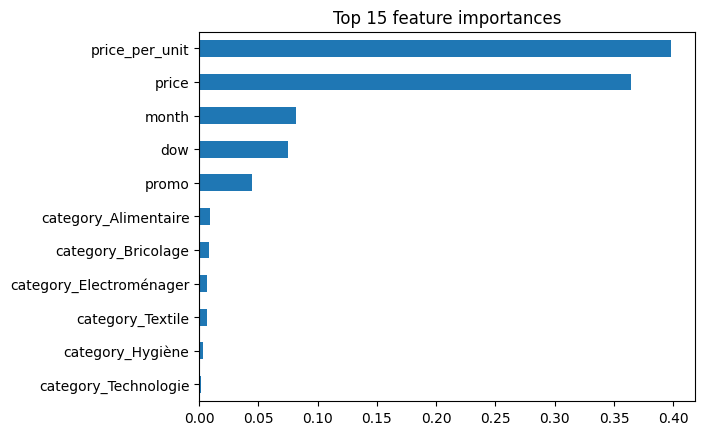

In [ ]:
plt.figure()
if 'coefs' in globals():
    coefs.head(15).plot(kind='barh')
    plt.title('Top 15 coefficients (importance approximative)')
elif 'imps' in globals():
    imps.head(15).plot(kind='barh')
    plt.title('Top 15 feature importances')
plt.gca().invert_yaxis()
plt.show()


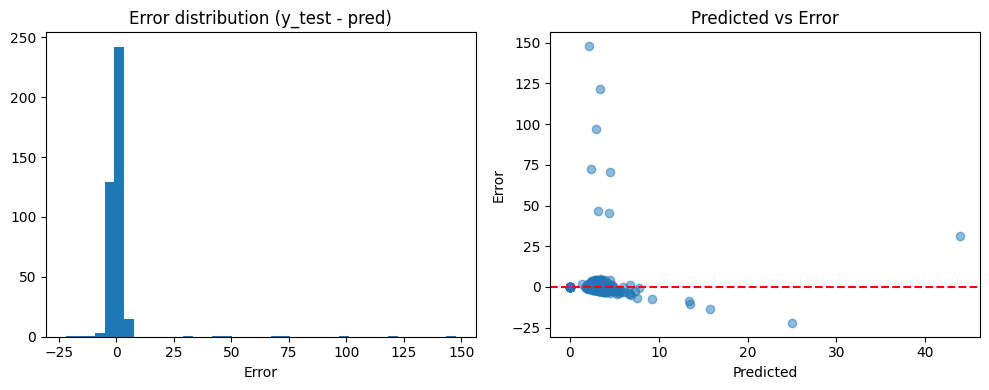

In [ ]:
# Error analysis
errors = y_test - pred
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(errors, bins=40)
plt.title('Error distribution (y_test - pred)')
plt.xlabel('Error')

plt.subplot(1,2,2)
plt.scatter(pred, errors, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Error')
plt.title('Predicted vs Error')
plt.tight_layout()
plt.show()


## 2. EXERCICE
- Remplacez `LinearRegression` par `RandomForestRegressor` et comparez MAE/R2.
- Ajoutez une feature `price_per_unit = total / max(quantity,1)` et observez l'impact.
- Créez un graphique des erreurs (`y_test - pred`).